# 检测图片

## 第一步实验

首先将一张图片分成n份27*27的图片，预测后print，查看是否仅有0，1（emm，论文好像是设置阈值，先输出看看

第一步实验结果：



In [1]:
import math
import torch.nn as nn

class Crack(nn.Module):
    def __init__(self, Crack_cfg):
        super(Crack, self).__init__()
        self.features = self._make_layers(Crack_cfg)
        # linear layer
#         self.classifier = nn.Linear(512, 10)
#         self.linear1 = nn.Linear(32*6*6,64)
#         self.linear2 = nn.Linear(64,64)
#         self.linear3 = nn.Linear(64,25)
        self.classifier = self.make_classifier()
    
    def make_classifier(self):
        classifier = []
        classifier += [nn.Linear(32*6*6,64),nn.ReLU(inplace=True),nn.Dropout(p=0.5)]
        classifier += [nn.Linear(64,64),nn.ReLU(inplace=True),nn.Dropout(p=0.5)]
        classifier += [nn.Linear(64,25)]
        return nn.Sequential(*classifier)
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
#         out = self.linear1(out)
#         out = self.linear2(out)
#         out = self.linear3(out)
        return out

    def _make_layers(self, cfg):
        """
        cfg: a list define layers this layer contains
            'M': MaxPool, number: Conv2d(out_channels=number) -> BN -> ReLU
        """
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
            
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [2]:
Crack_cfg = {
    'Crack11':[16,16,'M',32,32,'M']
}

model_t = Crack(Crack_cfg['Crack11']);

In [3]:
from functools import partial
import pickle
import torch
# pickle.load = partial(pickle.load, encoding="latin1")
# pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
# model = torch.load('D:\\大三下\\人工神经网络\\crack.pt', map_location=lambda storage, loc: storage, pickle_module=pickle)


# model = torch.load('D:/大三下/人工神经网络/best.pt')
model = torch.load('D:/大三下/ANN/crack.pt')
model_t.load_state_dict(model)

model_t.eval()
device = "cpu"

In [4]:
device = 'cpu'

In [5]:


"""
 1.需要将图片reshape成,长和宽都是27的倍数
 2.切割图片
 3.将这批图片处理成4元tuple，正则化到[-1,1]区间
 4.将图片用模型检验
 5.print实验结果 
 6.将tensor转换成图片
"""


import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from torch.autograd import Variable

from skimage import io, transform
from torchvision import transforms, utils

test_trainsforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def classify(img):
    # 切分为imgNum^2份
    width_num = img.shape[0]//(27)    
    print(width_num)
    height_num = img.shape[1]//(27)
    print(height_num)
    # 分割图片
    img_roi = []
    for i in range(width_num):  # [1]480*360==15*11---height
        for j in range(height_num):  # [2]column-----------width
            img_roi.append(img[(i * 27):((i + 1) * 27), (j * 27):((j + 1) * 27)])

    # 转换图片并开始识别
    t = img_roi[0]
    t = to_pil(t)
    t = test_trainsforms(t).float()
    t = t.unsqueeze_(0)
    # print(t.size())
    for i in range(len(img_roi)):
        if i != 0 :
            te = img_roi[i]
            te = to_pil(te)
            te = test_trainsforms(te).float()
            te = te.unsqueeze_(0)
            t = torch.cat((t,te),0)
            # print(t.size())
    return predict_img(t)

def classify_v2(img):
    #对像素逐一采样并输出，会迭代（480-27）*（320-27）次
    width = img.shape[0]
    height = img.shape[1]
    arr = []
    for i in range(width):
        for j in range(height):
            if(i-27 >= 0 and i + 27 <= width and j - 27 >= 0 and j + 27 <= height):
                t = img[i:i+27,j:j+27]
                t = to_pil(t)
                t = test_trainsforms(t).float()
                t = t.unsqueeze_(0)
                temp = predict_img(t)
#                 if(i % 27 == 0):
#                 print(temp)
                arr.append(np.sum(np.array(temp)))
        if(i % 100 == 0):
            print(i)
    return arr
# 	# print(st)
# 	# 对目标进行定位
# 	loc = []
# 	for i in st:
# 	    x = i % imgNum
# 	    y = i // imgNum
# 	    loc.append([x,y])
# 	# print(loc)
# 	# 在图片上标记目标
# 	for i in loc:
# 	    cv2.rectangle(img, (i[0]*imw,i[1]*imh), (i[0]*imw+imw,i[1]*imh+imh), (255,0,0), 3)
# 	# cv2.rectangle(img, 左上角, 右下角, （r，g，b）, 粗细（1，2，3，，）)
# 	# 返回已画好的图片
# 	return img 

In [6]:
def predict_img(inputs):
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model_t(inputs)
        imgNum = inputs.size()[0]
        _,preds = torch.max(outputs,1)
        std = []
#         print(preds)
        return outputs
#         for j in range(inputs.size()[0]):
#             # ax = plt.subplot(imgNum//2,2,j+1)
#             # ax.axis('off')
#             # ax.set_title('predicted: {}'.format(classname[preds[j]]))
#             if preds[j] == 0:
#                 std.append(j)
#             # imshow(inputs.cpu().data[j])
#         return std

In [7]:
to_pil = transforms.ToPILImage()

In [8]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


In [9]:
#-*-coding:utf-8-*-
import torch
from torchvision import transforms
from PIL import Image
import cv2



# if __name__ == '__main__':
file = "I:/1裂缝检测/CrackForest-dataset/image/001.jpg"

img = io.imread(file)
#     print(classify(img))
inp = classify_v2(img)
# print(inp.shape)
# inp = inp.numpy();
# inp = inp.reshape(187,5,5)
# print(inp.shape)

#此处需要将其转化成灰度图
    
# mean = np.array([0.5,0.5,0.5,1])
# std = np.array([0.5,0.5,0.5,0])
# inp = std * inp[1] + mean
# inp = np.clip(inp[1], 0, 1)
    
#     new_img_PIL = transforms.ToPILImage()(out).convert('RGB')
#     new_img_PIL.show() # 处理后的PIL图片
#     output = classify(img)
#     print(output)
#     imshow(output[1]);

# 	files = os.listdir(path)
# 	file_paths=[]#构造一个存放图片的列表数据结构
# 	for file in files:
# 	    file_path= path +"\\" + file
# 	    file_paths.append(file_path)
# 	st = '../testdata/img8/'
# 	for i in range(len(file_paths)):
# 		img = io.imread(file_paths[i])
# 		img = classify(img,imgNum) # 将图片分成imgNum*imgNum份进行识别
# 		plt.imshow(img)
# 		img_name = st + str(i) + '.jpg'
# 		print(img_name)
# 		cv2.imwrite(img_name,img)
# 		if(i>100):
# 			break;

0
100
200
300


In [10]:
temp = np.array(inp)
print(temp.size)

114009


In [11]:
temp.resize(320-54,480-54)
print(temp.shape)

(266, 426)


In [12]:
print(temp)

[[18.46027  19.976547 19.850603 ... 18.495457 17.975079 18.07963 ]
 [17.741035 19.139206 20.19507  ... 17.858791 17.852163 17.900211]
 [17.612871 17.759375 19.195427 ... 18.822962 17.78648  18.352   ]
 ...
 [20.185331 20.432692 19.50629  ... 21.45198  20.976822 21.47798 ]
 [21.44425  21.940107 21.365053 ... 20.744356 20.154053 20.685764]
 [19.786856 20.62594  20.03652  ... 21.256315 20.920471 21.815409]]


In [13]:
np.savetxt('input.csv', temp, delimiter = ',')

In [14]:
t = temp

t = (t - np.min(t))/(np.max(t)-np.min(t))
print(t)

[[0.2854791  0.3976092  0.3882955  ... 0.2880812  0.24959874 0.25733042]
 [0.23229104 0.33568704 0.4137692  ... 0.2409992  0.24050905 0.24406224]
 [0.22281317 0.23364724 0.33984464 ... 0.3123005  0.2356517  0.27747238]
 ...
 [0.41304898 0.4313415  0.36283326 ... 0.5067189  0.47158045 0.5086415 ]
 [0.5061472  0.5428163  0.5002905  ... 0.45438936 0.4107359  0.45005646]
 [0.38358134 0.44563243 0.40204424 ... 0.49224922 0.46741325 0.5335947 ]]


In [15]:
# t = temp
t[t>0.65] = 1
t[t <= 0.65] = 0


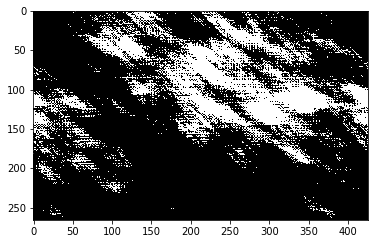

In [16]:
plt.imshow(t, cmap=plt.cm.gray, interpolation='nearest')

In [40]:
t = np.array(inp[1])
t[t > 0] = 1
t[t<=0] = 0
# t = inp.reshape(11*5,17*5)
t = np.empty([11*5,17*5],dtype=int)

In [ ]:
import cv2
for i in range(10):
    for j in range(16):
        t[i*5:i*5+5,j*5:(j+1)*5] = inp[16*i+j]

In [ ]:
# print(t[0:5,5:10])
# print(inp[117])
# print(inp[116])
temp = np.array(inp)
temp.resize(11*5,17*5)
print(temp.shape)
np.savetxt('t.csv', t, delimiter = ',')
np.savetxt('inp.csv', temp, delimiter = ',')
print(inp.shape)

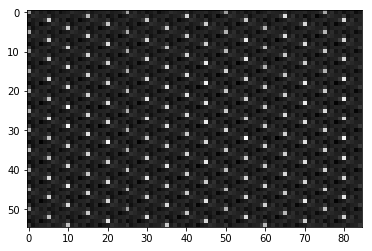

In [122]:
img = temp;
# temp = ((temp-np.min(img)))/(np.max(img)-np.min(img))
plt.imshow(temp, cmap=plt.cm.gray, interpolation='nearest')

In [103]:
img = t;
t = ((t-np.min(img)))/(np.max(img)-np.min(img))
print(t)
np.savetxt('new2.csv', t, delimiter = ',')
# print(t.shape)
# print(np.argwhere(t > 0.5).size)

# plt.imshow(t, cmap=plt.cm.gray, interpolation='nearest')

[[3.03334566e-09 6.06669126e-09 6.06669126e-09 ... 6.06669126e-09
  6.06669126e-09 6.06669126e-09]
 [6.37002585e-09 6.06669126e-09 6.06669126e-09 ... 6.06669126e-09
  6.06669126e-09 6.06669126e-09]
 [6.06669126e-09 6.06669126e-09 6.06669126e-09 ... 6.06669126e-09
  6.06669126e-09 6.06669126e-09]
 ...
 [9.59317021e-01 9.59317021e-01 9.59317021e-01 ... 9.59317021e-01
  9.59317021e-01 9.59317021e-01]
 [9.59317021e-01 9.59317021e-01 9.59317021e-01 ... 9.59317021e-01
  9.59317021e-01 9.59317021e-01]
 [9.59317021e-01 9.59317021e-01 9.59317021e-01 ... 9.59317021e-01
  9.59317021e-01 9.59317021e-01]]


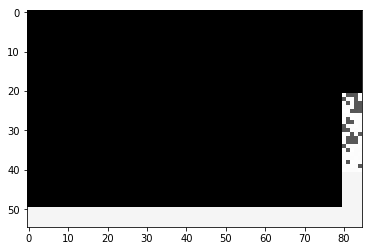

In [104]:
# temp = np.array(t)
# temp[temp < 1] = 0
plt.imshow(temp, cmap=plt.cm.gray, interpolation='nearest')

In [98]:
print(inp[0])

[[ 1.08163738e+01 -3.32994014e-01  8.34247231e-01 -6.64817572e-01
   1.34698898e-01]
 [-1.28444409e+00 -6.46651685e-01  2.83206105e-01 -1.62072062e+00
  -6.97971821e-01]
 [-3.15533012e-01  8.20260882e-01  3.15951467e-01  2.77510937e-02
  -5.54200727e-04]
 [ 1.21174002e+00 -9.88388896e-01 -2.14578599e-01  7.21678883e-02
   1.19841516e-01]
 [ 6.23069048e-01 -4.87565637e-01 -4.99401614e-02  1.32870063e-01
   1.35973668e+00]]


In [31]:
print(inp[1])

[[ 1.6236370e+01 -3.8423282e-01  1.2442583e+00 -1.0688343e+00
   2.2348273e-01]
 [-1.9327322e+00 -9.1323298e-01  4.2273441e-01 -2.4899380e+00
  -1.1130682e+00]
 [-4.7808108e-01  1.2940669e+00  5.4051685e-01 -1.0369082e-02
  -8.1067957e-02]
 [ 1.9045973e+00 -1.4466017e+00 -3.2824543e-01  2.1919766e-01
   2.2019877e-01]
 [ 9.4612408e-01 -8.0150169e-01 -5.4314751e-02  7.0221573e-02
   2.1187606e+00]]
